## Новый код

In [1]:
import datetime
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torch.nn as nn
from torcheval.metrics.functional import multiclass_accuracy

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

import cv2
from keras.utils import to_categorical

import PIL.Image

from os.path import join as pjoin
import os

from tqdm import tqdm
import json

In [2]:
import sklearn.utils

In [3]:
from utils import test_i_sample, test_x_sample
from my_dataset import MyDataset
from tf_callback import images_to_probs, plot_classes_preds, plot_confusion_matrix, plot_to_image
from metrics import runningScore

In [4]:
now = datetime.datetime.now()
model_name = f'model_{now.strftime("%d%m_%H%M")}'

In [5]:
print(model_name)

model_0407_1258


In [6]:
python_seed = 245
np_seed = 123
torch_seed = 321
torch_cuda_seed = 111
step = 50
split_test = 0.15
learning_rate = 0.001

In [7]:
batch_size = 8
num_epochs = 150
num_classes = 6

In [8]:
params_dict = {
    'python_seed' : python_seed,
    'np_seed' : np_seed,
    'torch_seed' : torch_seed,
    'torch_cuda_seed' : torch_cuda_seed,
    'step' : step,
    'split_test' : split_test,
    'learning_rate' : learning_rate,
    'batch_size' : batch_size,
    'num_epochs' : num_epochs,
    'num_classes' : num_classes
}

In [9]:
if not os.path.exists(pjoin('models', model_name)):
    os.makedirs(pjoin('models', model_name))
with open(pjoin('models', model_name, 'params.json'), 'w') as f:
    json.dump(params_dict, f)

In [10]:
torch.use_deterministic_algorithms(True)

In [11]:
random.seed(python_seed)
np.random.seed(np_seed)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_cuda_seed)


### Create train and val datasets

In [12]:
im_shape=(401,701)
iline, xline = im_shape
vert_locations = np.arange(0, iline, step)
horz_locations = np.arange(0, xline, step)

In [13]:
vert_mask = np.array(vert_locations) // step % round(1 / split_test) == 0
horz_mask = np.array(horz_locations) // step % round(1 / split_test) == 0
p_tr_list = ['i_' + str(ii) for ii in vert_locations[~vert_mask]] + ['x_' + str(ii) for ii in horz_locations[~horz_mask]]
p_vl_list = ['i_' + str(ii) for ii in vert_locations[vert_mask]] + ['x_' + str(ii) for ii in horz_locations[horz_mask]]

In [14]:
vert_mask, horz_mask

(array([ True, False, False, False, False, False, False,  True, False]),
 array([ True, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True]))

In [15]:
random.shuffle(p_tr_list)
# random.shuffle(p_vl_list)

In [16]:
len(p_tr_list), len(p_vl_list)

(19, 5)

In [17]:
path_data = 'data'

In [18]:
path_splits = pjoin(path_data, 'splits')
    
if not os.path.exists(path_splits):
    os.makedirs(path_splits)

In [19]:
file_object = open(pjoin(path_splits, 'train.txt'), 'w')
file_object.write('\n'.join(p_tr_list))
file_object.close()

file_object = open(pjoin(path_splits, 'val.txt'), 'w')
file_object.write('\n'.join(p_vl_list))
file_object.close()

### Сохраняем пример снимка и меток

In [20]:
# seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
# labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))
# np.save('seismic_example_i.npy', seismic[131])
# np.save('labels_example_i.npy', labels[131])
# np.save('seismic_example_i_1.npy', seismic[-43])
# np.save('labels_example_i_1.npy', labels[-43])

# np.save('seismic_example_x.npy', seismic[:,246])
# np.save('labels_example_x.npy', labels[:,246])
# np.save('seismic_example_x_1.npy', seismic[:,-23])
# np.save('labels_example_x_1.npy', labels[:,-23])

### Трансформация (кроп) torchvision transforms

In [21]:
rand_crop_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=1, padding_mode='edge'),
    transforms.RandomCrop(256),
    transforms.RandomVerticalFlip(p=0.5)
])

#### Проверка трансформации

In [22]:
seismic_example_i = np.load('seismic_example_i.npy')
labels_example_i = np.load('labels_example_i.npy')
labels_cat_example_i = to_categorical(labels_example_i, num_classes=6)

seismic_example_i_1 = np.load('seismic_example_i_1.npy')
labels_example_i_1 = np.load('labels_example_i_1.npy')
labels_cat_example_i_1 = to_categorical(labels_example_i_1, num_classes=6)

In [23]:
seismic_example_x = np.load('seismic_example_x.npy')
labels_example_x = np.load('labels_example_x.npy')
labels_cat_example_x = to_categorical(labels_example_x, num_classes=6)

seismic_example_x_1 = np.load('seismic_example_x_1.npy')
labels_example_x_1 = np.load('labels_example_x_1.npy')
labels_cat_example_x_1 = to_categorical(labels_example_x_1, num_classes=6)

In [24]:
labels_cat_example_i.shape

(701, 255, 6)

In [25]:
np.expand_dims(seismic_example_i, axis=-1).shape

(701, 255, 1)

In [26]:
stacked = np.dstack([np.expand_dims(seismic_example_i, axis=-1), labels_cat_example_i])
stacked = rand_crop_1(stacked)
im, lbl = stacked[0], stacked[1:]
print(im.shape, lbl.shape)

torch.Size([256, 256]) torch.Size([6, 256, 256])


In [27]:
lbl[lbl % 1 != 0] #.round().int()

tensor([], dtype=torch.float64)

In [28]:
np.argmax(lbl, axis=0)

tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5]])

In [29]:
seismic_arr_i = np.array([seismic_example_i, seismic_example_i_1])
labels_cat_arr_i = np.array([labels_cat_example_i, labels_cat_example_i_1])

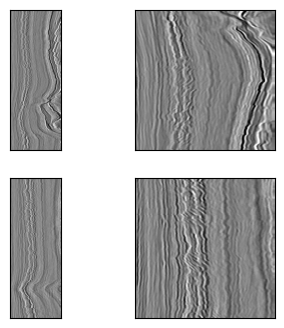

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(seismic_arr_i):
    axs[i][0].imshow(image, cmap='gray')
    axs[i][1].imshow(rand_crop_1(image).permute(1,2,0), cmap='gray')
for i in range(2):
    for j in range(2):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

In [31]:
# нарисовать через opencv привязать метки к классам

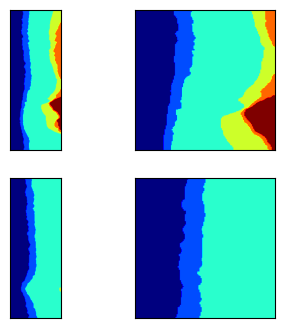

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(labels_cat_arr_i):
    axs[i][0].imshow(np.argmax(image,axis =-1), cmap='jet', vmin=0, vmax=5)
    axs[i][1].imshow(np.argmax(rand_crop_1(image).permute(1,2,0), axis=-1), cmap='jet', vmin=0, vmax=5)

for i in range(2):
    for j in range(2):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

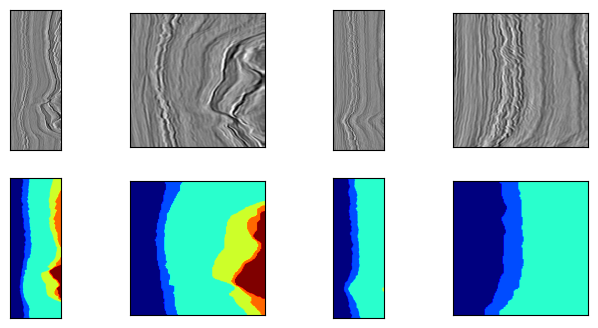

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
for i, image in enumerate(seismic_arr_i):
    stacked = np.dstack([np.expand_dims(image, axis=-1), labels_cat_arr_i[i]])
    stacked = rand_crop_1(stacked)
    im, lbl = stacked[0], stacked[1:]
    axs[0][2*i].imshow(image, cmap='gray')
    axs[0][2*i+1].imshow(im, cmap='gray')
    axs[1][2*i].imshow(np.argmax(labels_cat_arr_i[i], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[1][2*i+1].imshow(np.argmax(lbl.permute(1,2,0), axis=-1), cmap='jet', vmin=0, vmax=5)
    for j in range(2):
        axs[j][2*i].xaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i].yaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i+1].xaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i+1].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

### Делаем загрузчик данных

In [34]:
train_dataset = MyDataset(split='train', transform=rand_crop_1)
val_dataset = MyDataset(split='val', transform=rand_crop_1)

In [35]:
len(train_dataset), len(val_dataset)

(19, 5)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Проверка DataLoader-ов

In [37]:
image_tensor, label_tensor = next(iter(train_loader))
len(train_loader)

3

In [38]:
image_tensor.shape, label_tensor.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 6, 256, 256]))

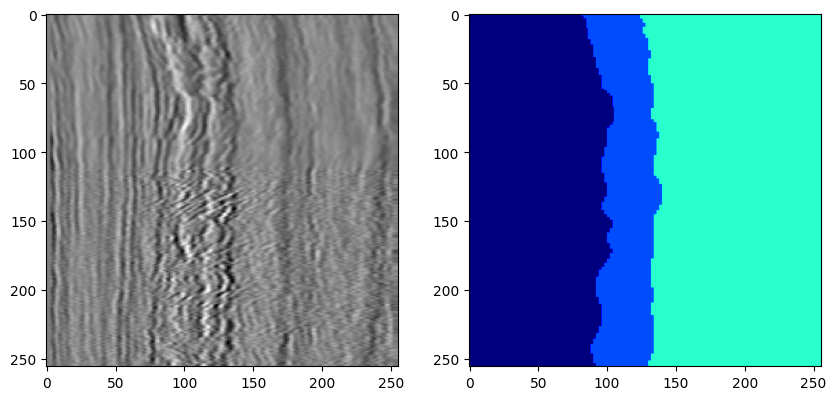

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axs[0].imshow(image_tensor[0,0,:,:], cmap='gray')
axs[1].imshow(np.argmax(label_tensor[0,:,:,:],axis=0), cmap='jet', vmin=0, vmax=5)
plt.show()

In [40]:
image_tensor.max(), image_tensor.min() # нормировка должна быть внутри класса

(tensor(1.), tensor(-1.))

### Моделька

In [41]:
# Создаем U-Net модель с энкодером resnet34
model = smp.Unet(
    encoder_name="resnet18", # resnet18 
    # encoder_weights="swsl", # можно обучать с нуля
    in_channels=1,
    classes=6,  # Количество классов для сегментации
)

### Loss, merics, optimizer

In [42]:
class_weights = None
calc_w = False

In [45]:
if calc_w:
    _lbls = np.array([])
    for i in range(len(train_dataset)):
        _, lbl = train_dataset[i]
        _lbls = np.append(_lbls, torch.argmax(lbl, dim=0).flatten().numpy())
    print(_lbls.shape)
    class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.arange(num_classes), y=_lbls)

In [ ]:
print(class_weights)

[0.58395848 1.4733534  0.34747472 2.23567137 6.89218779 7.21845797]


In [137]:
if calc_w:
    params_dict['class_weights'] = dict(zip(range(num_classes),class_weights))
    with open(pjoin('models', model_name, 'params.json'), 'w') as f:
        json.dump(params_dict, f)

In [46]:
# # Определяем функцию потерь и оптимизатор
loss = None
if calc_w:
    loss = [smp.utils.losses.DiceLoss(), nn.CrossEntropyLoss(weight=torch.Tensor(class_weights))]
else:
    loss = [smp.utils.losses.DiceLoss(), nn.CrossEntropyLoss()]
metrics = [smp.utils.metrics.IoU(threshold=0.5)] # threshold ?? 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss = [smp.losses.DiceLoss('multiclass'), smp.losses.SoftCrossEntropyLoss()]
# metrics = smp.metrics.iou_score

In [139]:
# Определяем устройство для обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [140]:
# Переносим модель и функцию потерь на устройство
model = model.to(device)
loss[0] = loss[0].to(device)
loss[1] = loss[1].to(device)

### Learning

#### Tensorboard settings

In [141]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(pjoin('models', model_name, 'runs'))

In [142]:
# helper functions



#### Training

In [143]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [144]:
len(train_loader), len(val_loader)

(3, 1)

In [145]:
if not os.path.exists(pjoin('models', model_name, 'disasters')):
    os.makedirs(pjoin('models', model_name, 'disasters'))

In [146]:
best_metric_arr = -np.ones(4)
best_model_arr = [model for i in range(4)]

In [147]:
best_metric_0 = -1
best_model_0 = model

In [148]:
running_loss = [0.0, 0.0]

In [149]:
metric_names = ['Pixel Acc', 'Mean Class Acc', 'Freq Weighted IoU', 'Mean IoU']

In [150]:
running_metrics = runningScore(num_classes)
running_metrics_val = runningScore(num_classes)

In [151]:
smp_loss_logs = np.zeros((num_epochs, len(loss)))
smp_iu_logs = np.zeros(num_epochs)

In [152]:
pa_logs = np.zeros(num_epochs)
ca_logs = np.zeros((num_epochs, num_classes))
mca_logs = np.zeros(num_epochs)
iu_logs = np.zeros((num_epochs, num_classes))
mciu_logs = np.zeros(num_epochs)
fwiu_logs = np.zeros(num_epochs)
cm_logs = np.zeros((num_epochs, num_classes, num_classes))

In [153]:
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Обучение
    model.train()

    running_loss = [0.0, 0.0]
    number_of_batches = len(train_loader)

    last_batch = (0,0)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # images.shape = torch.Size([batch_size, 1, 256, 256])
        # labels.shape = torch.Size([batch_size, 6, 256, 256])

        optimizer.zero_grad()

        outputs = model(images)
        # outputs.shape = torch.Size([batch_size, 6, 256, 256])
        outputs = nn.Softmax(dim=1)(outputs)
        # outputs_lbl.shape = torch.Size([batch_size, 6, 256, 256])

        outputs_lbl = np.argmax(outputs.detach().numpy(), axis=1)
        labels_trues = np.argmax(labels.reshape(outputs.shape), axis=1)

        for i, l in enumerate(loss):
            running_loss[i] += l(outputs, labels.reshape(outputs.shape)).item()

        running_metrics.update(labels_trues, outputs_lbl)

        loss_value = loss[0](outputs, labels.reshape(outputs.shape)) + loss[1](outputs, labels.reshape(outputs.shape))
        loss_value.backward()
        optimizer.step()
    
        last_batch = (images, labels)

        if loss_value.item() < 0:
            np.save(pjoin('models', model_name, 'disasters',
                          f'nl_output_{epoch}_{i}.npy'),
                          outputs.detach().numpy())

    # log loss[0]
    writer.add_scalar('train/DiceLoss',
                      running_loss[0] / number_of_batches,
                      epoch+1)
    smp_loss_logs[0] = running_loss[0] / number_of_batches

    # log loss[1]
    writer.add_scalar('train/CrossEntropyLoss',
                      running_loss[1] / number_of_batches,
                      epoch+1)
    smp_loss_logs[1] = running_loss[1] / number_of_batches
    
    # log the running loss
    writer.add_scalar('train/loss(sum)',
                      sum(running_loss) / number_of_batches,
                      epoch+1)

    # log a Matplotlib Figure showing the model's predictions on a
    # last mini-batch
    # print(last_batch)
    # print(last_batch[0].shape, last_batch[1].shape)
    writer.add_figure(f'train/true vs pred',
                      plot_classes_preds(model, last_batch[0], last_batch[1], epoch),
                      global_step = epoch+1)

    score, class_iu = running_metrics.get_scores()

    for m in metric_names:
        writer.add_scalar(f'train/{m}',
                          score[f'{m}: '], epoch+1)

    # pa_logs[epoch] = score['Pixel Acc: ']
    # mca_logs[epoch] = score['Mean Class Acc: ']
    # fwiu_logs[epoch] = score['Freq Weighted IoU: ']
    # mciu_logs[epoch] = score['Mean IoU: ']

    for i, _ca in enumerate(score['Class Accuracy: ']):
        writer.add_scalar(f'train/Class[{i}] Accuracy',
                          _ca, epoch+1)
        # ca_logs[epoch][i] = _ca

        writer.add_scalar(f'train/Class[{i}] IoU',
                          class_iu[i], epoch+1)
        # iu_logs[epoch][i] = class_iu[i]

    cm = score['confusion_matrix']

    writer.add_figure(f'train/Confusion Matrix',
                      plot_confusion_matrix(cm, list(range(num_classes))),
                      global_step = epoch+1)
    # cm_logs[epoch] = cm

    running_metrics.reset()


    # Валидация
    model.eval()
    total_metric_0 = 0
    num_samples = 0
    number_of_batches = len(val_loader)

    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        number_of_batches = len(val_loader)
        
        with torch.no_grad():
            outputs = model(images)
            # outputs.shape = torch.Size([batch_size, 6, 256, 256])
            outputs = nn.Softmax(dim=1)(outputs)
            # outputs.shape = torch.Size([batch_size, 6, 256, 256])
            
            outputs_lbl = np.argmax(outputs.detach().numpy(), axis=1)
            labels_trues = np.argmax(labels.reshape(outputs.shape), axis=1)

            metric_value_0 = metrics[0](outputs, labels.reshape(outputs.shape))
            total_metric_0 += metric_value_0.item() * images.size(0)

            running_metrics_val.update(labels_trues, outputs_lbl)
            

            num_samples += images.size(0)
            
            last_batch = (images, labels)

    writer.add_figure(f'val/true vs pred',
        plot_classes_preds(model, last_batch[0], last_batch[1], epoch),
        global_step=epoch)
        
    average_metric_0 = total_metric_0 / num_samples

    writer.add_scalar('val/smp_metrics',
                      average_metric_0,
                      epoch+1)

    score, class_iu = running_metrics_val.get_scores()

    for m in metric_names:
        writer.add_scalar(f'val/{m}',
                          score[f'{m}: '], epoch+1)

    pa_logs[epoch] = score['Pixel Acc: ']
    mca_logs[epoch] = score['Mean Class Acc: ']
    fwiu_logs[epoch] = score['Freq Weighted IoU: ']
    mciu_logs[epoch] = score['Mean IoU: ']

    for i, _ca in enumerate(score['Class Accuracy: ']):
        writer.add_scalar(f'val/Class[{i}] Accuracy',
                          _ca, epoch+1)
        ca_logs[epoch][i] = _ca

        writer.add_scalar(f'val/Class[{i}] IoU',
                          class_iu[i], epoch+1)
        iu_logs[epoch][i] = class_iu[i]

    cm = score['confusion_matrix']

    writer.add_figure(f'val/Confusion Matrix',
                      plot_confusion_matrix(cm, list(range(num_classes))),
                      global_step = epoch+1)
    cm_logs[epoch] = cm

    running_metrics_val.reset()
    
    # Вывод прогресса обучения
    # print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_value.item():.4f}, Metric: {average_metric:.4f}')

    # сохранение чекпойнта (если метрика стала лучше)
    if best_metric_0 < average_metric_0:
        best_metric_0 = average_metric_0
        best_model_0 = model
    
    for i, m in enumerate(metric_names):
        if best_metric_arr[i] < score[f'{m}: ']:
            best_metric_arr[i] = score[f'{m}: ']
            best_model_arr[i] = model


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\tf_callback.py:72: RuntimeWarning: invalid value encountered in divide
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
Epochs:   3%|▎         | 4/150 [01:04<39:54, 16.40s/it]z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\tf_callback.py:72: RuntimeWarning: invalid value encountered in divide
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
Epochs:   3%|▎         | 5/150 [01:20<38:53, 16.09s/it]z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\tf_callback.py:72: RuntimeWarning: invalid value encountered in divide
  labels = np.around(cm.

In [154]:
print(number_of_batches)

1


In [155]:
print(f'best_metric_0 = {best_metric_0}')

best_metric_0 = 0.9735608696937561


In [156]:
for i, m in enumerate(metric_names):
    print(f'best_metric[{m}] = {best_metric_arr[i]}')

best_metric[Pixel Acc] = 0.9866363525390625
best_metric[Mean Class Acc] = 0.978559173917197
best_metric[Freq Weighted IoU] = 0.974060214445169
best_metric[Mean IoU] = 0.9529368579056507


In [157]:
torch.save(best_model_0.state_dict(), pjoin('models', model_name, f'best_0_{model_name}.pth'))
for i, m in enumerate(metric_names):
    torch.save(best_model_arr[i].state_dict(), pjoin('models', model_name, f'best_{m}_{model_name}.pth'))

In [158]:
if not os.path.exists(pjoin('models', model_name, 'logs')):
    os.makedirs(pjoin('models', model_name, 'logs'))

In [159]:
np.save(pjoin('models', model_name, 'logs', 'smp_loss_logs.npy'),   smp_loss_logs)
np.save(pjoin('models', model_name, 'logs', 'smp_iu_logs.npy'), smp_iu_logs)
np.save(pjoin('models', model_name, 'logs', 'pa_logs.npy'), pa_logs)
np.save(pjoin('models', model_name, 'logs', 'ca_logs.npy'), ca_logs)
np.save(pjoin('models', model_name, 'logs', 'mca_logs .npy'),   mca_logs )
np.save(pjoin('models', model_name, 'logs', 'iu_logs.npy'), iu_logs)
np.save(pjoin('models', model_name, 'logs', 'mciu_logs.npy'), mciu_logs)
np.save(pjoin('models', model_name, 'logs', 'fwiu_logs.npy'),   fwiu_logs)
np.save(pjoin('models', model_name, 'logs', 'cm_logs.npy'), cm_logs)

In [160]:
# model.load_state_dict(torch.load(pjoin('models', model_name, f'{model_name}.pth')))
# model = last_model

In [49]:
model.load_state_dict(torch.load(pjoin('models', 'model_0307_0825', f'best_0_model_0307_0825.pth')))

<All keys matched successfully>

In [50]:
# best_model = best_model_0
best_model = model

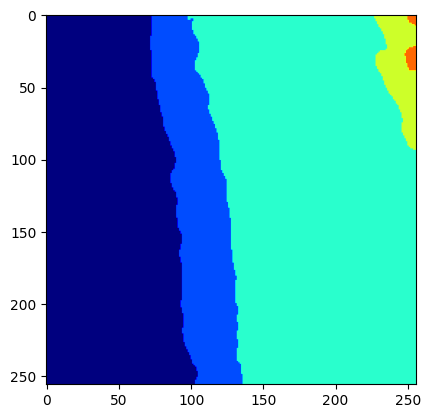

In [51]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
image_tensor, label_tensor = next(iter(train_loader))
output = nn.Softmax(dim=1)(best_model(image_tensor))
output = output.detach().numpy()
plt.imshow(np.argmax(output,axis=1)[0], cmap='jet', vmin=0, vmax=5)
plt.show()

### Тестируем на полном срезе

In [52]:
seismic_example_i_1.shape, labels_cat_example_i_1.shape

((701, 255), (701, 255, 6))

In [53]:
seismic_example_x_1.shape, labels_cat_example_x_1.shape

((401, 255), (401, 255, 6))

In [54]:
running_metrics_test = runningScore(num_classes)

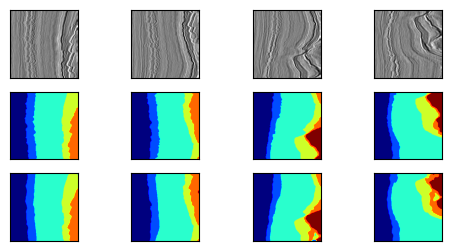

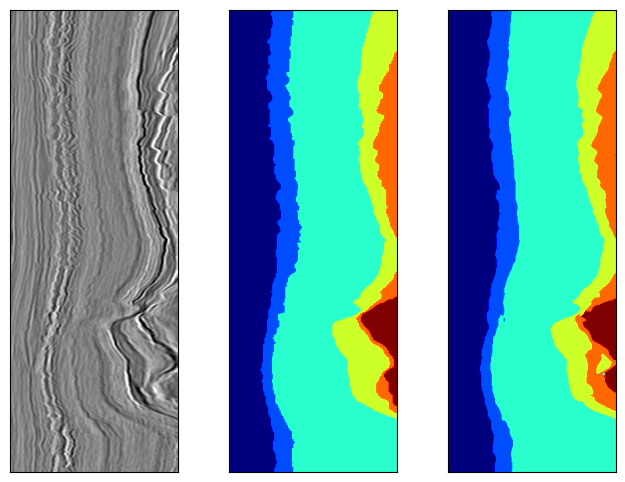

NameError: name 'metric_names' is not defined

In [55]:
_, true_lbls, outputs = test_i_sample(best_model, seismic_example_i, labels_cat_example_i, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, class_iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')


_, true_lbls, outputs = test_i_sample(best_model, seismic_example_i_1, labels_cat_example_i_1, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, class_iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')



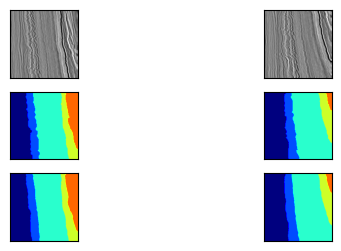

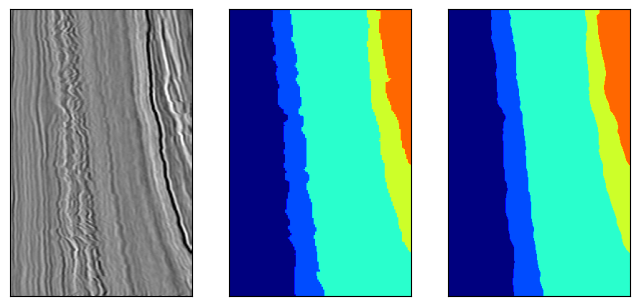

z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\metrics.py:36: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Pixel Acc: 	0.9858588822062491
Mean Class Acc: 	0.9843867180189989
Freq Weighted IoU: 	0.9724601089885456
Mean IoU: 	0.9608171764978239
Class[0] Accuracy:	0.9935957868729886
Class[0] IoU:     	0.9862336865778444
Class[1] Accuracy:	0.9763114754098361
Class[1] IoU:     	0.9220213545079597
Class[2] Accuracy:	0.9841938171256164
Class[2] IoU:     	0.9842642605139093
Class[3] Accuracy:	0.9720398735716023
Class[3] IoU:     	0.17419354838709677
Class[4] Accuracy:	0.9957926371149511
Class[4] IoU:     	0.0
Class[5] Accuracy:	nan
Class[5] IoU:     	nan


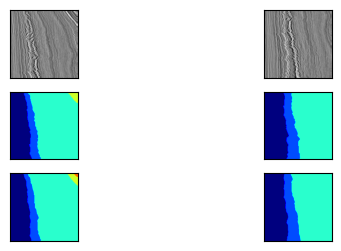

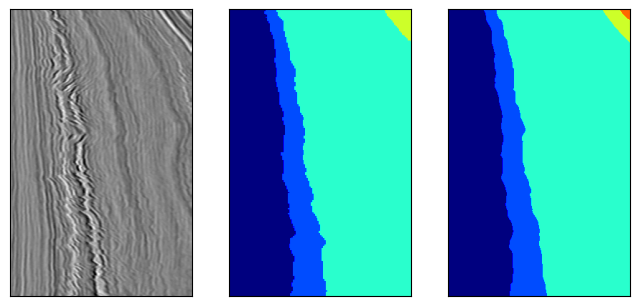

Pixel Acc: 	0.988900298273923
Mean Class Acc: 	0.9496327490303731
Freq Weighted IoU: 	0.9798125131519123
Mean IoU: 	0.7442091020907322
Class[0] Accuracy:	0.9926332133064649
Class[0] IoU:     	0.9862336865778444
Class[1] Accuracy:	0.9669274824554328
Class[1] IoU:     	0.9220213545079597
Class[2] Accuracy:	0.9941594371200219
Class[2] IoU:     	0.9842642605139093
Class[3] Accuracy:	0.8448108632395732
Class[3] IoU:     	0.17419354838709677
Class[4] Accuracy:	nan
Class[4] IoU:     	0.0
Class[5] Accuracy:	nan
Class[5] IoU:     	nan


z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\metrics.py:36: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


In [ ]:
_, true_lbls, outputs = test_x_sample(best_model, seismic_example_x, labels_cat_example_x, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')


_, true_lbls, outputs = test_x_sample(best_model, seismic_example_x_1, labels_cat_example_x_1, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')

### Тестируем на всех срезах i и x

In [56]:
seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))

In [169]:
data_shape = seismic.shape

In [170]:
pred_labels_cat_i = np.zeros((data_shape[0], data_shape[1], data_shape[2], 6))

In [171]:
for i in tqdm(range(data_shape[0])):
    im = seismic[i]
    lbl = to_categorical(labels[i], num_classes=6)
    _, lbl_cat, pred_lbl_cat = test_i_sample(best_model, im, lbl, False)
    pred_labels_cat_i[i] = pred_lbl_cat

100%|██████████| 401/401 [06:52<00:00,  1.03s/it]


In [172]:
np.save(pjoin('models', model_name, 'pred_labels_cat_i.npy'), pred_labels_cat_i)

In [173]:
pred_labels_cat_x = np.zeros((data_shape[0], data_shape[1], data_shape[2], 6))

In [174]:
for i in tqdm(range(data_shape[1])):
    im = seismic[:,i]
    lbl = to_categorical(labels[:,i], num_classes=6)
    _, lbl_cat, pred_lbl_cat = test_x_sample(best_model, im, lbl, False)
    pred_labels_cat_x[:,i,:,:] = pred_lbl_cat

100%|██████████| 701/701 [05:56<00:00,  1.97it/s]


In [175]:
np.save(pjoin('models', model_name, 'pred_labels_cat_x.npy'), pred_labels_cat_x)

In [176]:
pred_labels_cat_i = np.load(pjoin('models', model_name, 'pred_labels_cat_i.npy'))
pred_labels_cat_x  = np.load(pjoin('models', model_name, 'pred_labels_cat_x.npy'))

In [177]:
print(model_name)

model_0407_1009


In [178]:
torch.from_numpy(np.expand_dims(np.moveaxis(labels[3], -1, 0), axis=0)).shape

torch.Size([1, 255, 701])

In [179]:
torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[3], -1, 0), axis=0)).shape

torch.Size([1, 6, 701, 255])

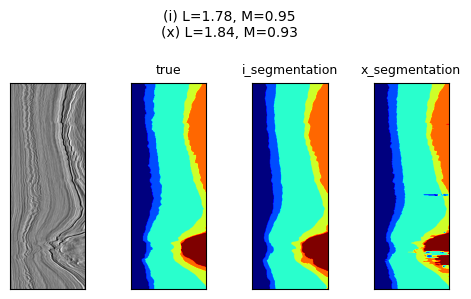

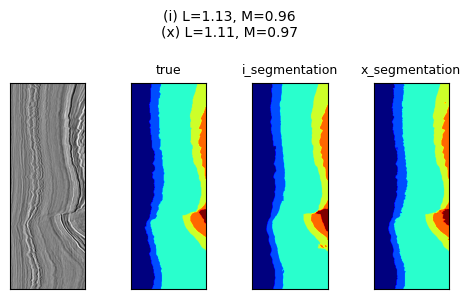

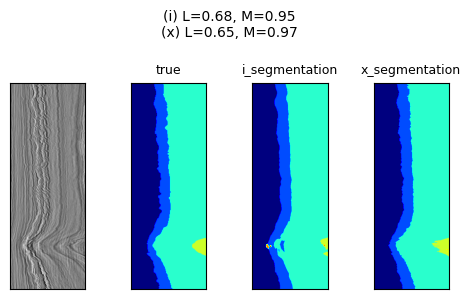

In [180]:
i_slices = [33, 156, 366]

for i, idx in enumerate(i_slices):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5, 3))
    axs[0].imshow(seismic[idx], cmap='gray')
    axs[1].imshow(labels[idx], cmap='jet', vmin=0, vmax=5)
    axs[1].set_title('true', fontsize=9)

    axs[2].imshow(np.argmax(pred_labels_cat_i[idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[2].set_title('i_segmentation', fontsize=9)

    axs[3].imshow(np.argmax(pred_labels_cat_x[idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[3].set_title('x_segmentation', fontsize=9)
    for j in range(4):
        axs[j].xaxis.set_major_locator(ticker.NullLocator())
        axs[j].yaxis.set_major_locator(ticker.NullLocator())

    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[idx],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[idx], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[idx], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)
    fig.suptitle(f'(i) L={li}, M={mi}\n(x) L={lx}, M={mx}', fontsize=10)
    plt.tight_layout()
    plt.show()

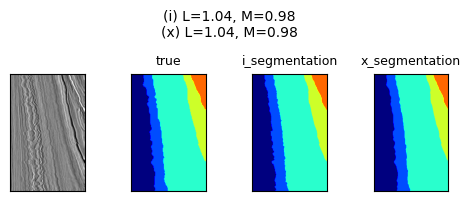

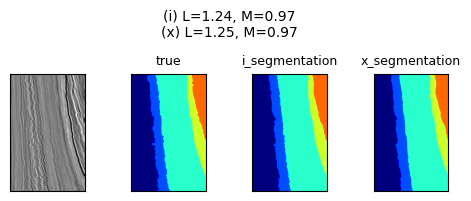

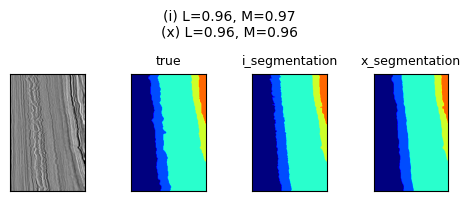

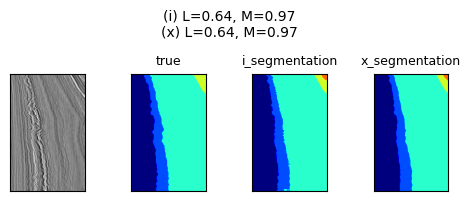

In [181]:
x_slices = [56, 236, 311, 666]
for i, idx in enumerate(x_slices):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5, 2))
    axs[0].imshow(seismic[:,idx], cmap='gray')
    axs[1].imshow(labels[:,idx], cmap='jet', vmin=0, vmax=5)
    axs[1].set_title('true', fontsize=9)

    axs[2].imshow(np.argmax(pred_labels_cat_i[:,idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[2].set_title('i_segmentation', fontsize=9)

    axs[3].imshow(np.argmax(pred_labels_cat_x[:,idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[3].set_title('x_segmentation', fontsize=9)
    for j in range(4):
        axs[j].xaxis.set_major_locator(ticker.NullLocator())
        axs[j].yaxis.set_major_locator(ticker.NullLocator())

    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[:,idx],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[:,idx], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[:,idx], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)
    fig.suptitle(f'(i) L={li}, M={mi}\n(x) L={lx}, M={mx}', fontsize=10)
    plt.tight_layout()
    plt.show()

In [182]:
for i in tqdm(range(data_shape[0])):
    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[i],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[i], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[i], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)

    writer.add_scalar('test/(i_algo) loss along i', li, i)
    writer.add_scalar('test/(i_algo) metric along i', mi, i)
    writer.add_scalar('test/(x_algo) loss along i', lx, i)
    writer.add_scalar('test/(x_algo) metric along i', mx, i)
    

100%|██████████| 401/401 [00:47<00:00,  8.40it/s]


In [183]:
for i in tqdm(range(data_shape[1])):
    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[:,i],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[:,i], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[:,i], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)

    writer.add_scalar('test/(i_algo) loss along x', li, i)
    writer.add_scalar('test/(i_algo) metric along x', mi, i)
    writer.add_scalar('test/(x_algo) loss along x', lx, i)
    writer.add_scalar('test/(x_algo) metric along x', mx, i)
    

100%|██████████| 701/701 [00:56<00:00, 12.39it/s]


#### full metric

In [184]:
lbl_i = torch.from_numpy(np.moveaxis(to_categorical(labels,num_classes=6), -1, 1))
pred_i = torch.from_numpy(np.moveaxis(pred_labels_cat_i, -1, 1))
lbl_x = torch.from_numpy(np.moveaxis(to_categorical(labels,num_classes=6), (1, -1), (0, 1)))
pred_x = torch.from_numpy(np.moveaxis(pred_labels_cat_x, (1, -1), (0, 1)))

li = torch.round(loss[0](pred_i, lbl_i) + loss[1](pred_i, lbl_i), decimals=2)
mi = torch.round(metrics[0](pred_i, lbl_i), decimals=2)
lx = torch.round(loss[0](pred_x, lbl_x) + loss[1](pred_x, lbl_x), decimals=2)
mx = torch.round(metrics[0](pred_x, lbl_x), decimals=2)

print(f'i_algo: loss={li}, metric={mi}')
print(f'x_algo: loss={lx}, metric={mx}')

i_algo: loss=1.09, metric=0.96
x_algo: loss=1.09, metric=0.96
